This notebook is used to test the `cartan_plugin.py` file and to make sure the plugin is installed correctly.

In [30]:
# Import the `cartan_plugin.py` file.
from qiskit_cartan.cartan_plugin import *

# Enable transpiler logging.
import logging
# logging.basicConfig(level='DEBUG')
logging.basicConfig()

# Set the overall random seed.
random.seed(1)

#### Check `synth_cartan` works as intended with an example 3 qubit Heisenberg Hamiltonian with next-nearest-neighbor interactions and open boundary conditions (3q NNN-open) with uniform coefficients (all equal to 1) and an evolution time of `t=3`. In the particular 3q case an NNN-open Ham is equivalent to a nearest-beighbor & open Ham (3q NN-open).

In [31]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import MatrixExponential

# Create a SparsePauliOp representation of the Hamiltonian to be rested.
ham_terms = ["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"]
test_heisenberg_ham = SparsePauliOp(data = ham_terms, 
                                    coeffs = np.ones(len(ham_terms), dtype=int)) # all coeffs are 1

# Time to evolve the Hamiltonian for.
test_time_evolve = 3

# Create the corresponding PauliEvolutionGate instance.
test_paulievolutiongate = PauliEvolutionGate(operator = test_heisenberg_ham, 
                                             time = test_time_evolve,
                                             synthesis= MatrixExponential())

# Test the high level synthesis works as intended.
qc = synth_cartan(paulievolutiongate=test_paulievolutiongate, 
                  random_seed=1,
                  involution="evenOdd")
print(qc)

Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
--- 0.03229188919067383 seconds ---
Optimization Error:
1.568316222819728e-10
     ┌────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                       ├┤0                        ├»
     │                        ││                         │»
q_1: ┤1 exp(-it XZY)(0.23183) ├┤1 exp(-it ZXY)(-0.23183) ├»
     │                        ││                         │»
q_2: ┤2                       ├┤2                        ├»
     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YXZ)(-0.21027) ├┤1 exp(-it YZX)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                 

In [32]:
from qiskit import Aer, transpile
import scipy
from qiskit.quantum_info import SparsePauliOp

# Retrieve the matrix corresponding to the above circuit.
unitary_simulator = Aer.get_backend('unitary_simulator')
qc_transp = transpile(qc, unitary_simulator)
final_unitary_cartan = unitary_simulator.run(qc_transp).result().get_unitary()


# Retrieve the matrix corresponding to that obtained by direct exponentiation of the Hamiltonian.
test_heisenberg_ham_matrix = test_heisenberg_ham.to_matrix()
propagator = scipy.linalg.expm(-1j*test_heisenberg_ham_matrix*test_time_evolve)
matrix_norm = np.linalg.norm(propagator - final_unitary_cartan)
print("\n")
print("matrix norm of the difference between the ideal propagator and that obtained by cartan decomposition: \n", 
      matrix_norm)

print("\n")
print(f"trace of their product (one of them is Hermitian transposed) divided by dimension: \n",
      np.trace(final_unitary_cartan.conjugate().transpose() @ propagator) / 2**(test_paulievolutiongate.num_qubits))




matrix norm of the difference between the ideal propagator and that obtained by cartan decomposition: 
 4.939392876340576e-06


trace of their product (one of them is Hermitian transposed) divided by dimension: 
 (0.9999999999984772+1.1723925695058824e-15j)


In [33]:
# double check using qiskit.quantum_info functionality
from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex

print("ideal propagator matrix: ")
display(array_to_latex(propagator))

print("cartan progagator matrix: ")
display(array_to_latex(final_unitary_cartan))

atol = 1e-4
rtol = 1e-7
print(f"are the two matrices element-wise equal up to a global phase, where atol = {atol} and rtol = {rtol}?",
      "\n", 
      Operator(propagator).equiv(Operator(final_unitary_cartan), atol=1e-4, rtol=1e-7))

# Notes on the above result:
# If the following inequality is True element-wise (up to global phase), 
# then .equiv() returns True overall:

# absolute(a - b) <= (atol + rtol * absolute(b)),
# for matrix element a of one matrix and the corresponding matrix element b
# of the other matrix.


ideal propagator matrix: 


<IPython.core.display.Latex object>

cartan progagator matrix: 


<IPython.core.display.Latex object>

are the two matrices element-wise equal up to a global phase, where atol = 0.0001 and rtol = 1e-07? 
 True


#### Check the HLS plugin is installed by inspecting a HighLevelSynthesisPluginManager instance.

In [34]:
from qiskit.transpiler.passes.synthesis.plugin import HighLevelSynthesisPluginManager

HLS_plugin_manager = HighLevelSynthesisPluginManager()
print(HLS_plugin_manager.plugins.names())

# Check that "PauliEvolution.cartan" is in the list.

['PauliEvolution.cartan', 'clifford.default', 'linear_function.default', 'permutation.acg', 'permutation.basic', 'permutation.default', 'permutation.kms']


#### Test the plugin by creating an empty PassManager and only using a HLS Config corresponding to our HLS pass.

In [35]:
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))
print("before: ")
qc_before.draw()

before: 


┌──────────────────────────────────────────────────┐
q_0: ┤0                                                 ├
     │                                                  │
q_1: ┤1 exp(-it (XXI + YYI + ZZI + IXX + IYY + IZZ))(3) ├
     │                                                  │
q_2: ┤2                                                 ├
     └──────────────────────────────────────────────────┘

In [36]:
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis

hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":1, "involution":"evenOdd"})])
pm = PassManager()
pm.append(HighLevelSynthesis(hls_config=hls_config))
qc_after = pm.run(qc_before)
qc_after.draw()

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
--- 0.0299990177154541 seconds ---
Optimization Error:
1.568316222819728e-10


┌────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                       ├┤0                        ├»
     │                        ││                         │»
q_1: ┤1 exp(-it XZY)(0.23183) ├┤1 exp(-it ZXY)(-0.23183) ├»
     │                        ││                         │»
q_2: ┤2                       ├┤2                        ├»
     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YXZ)(-0.21027) ├┤1 exp(-it YZX)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                        ├┤2                       ├»
«     └─────────────────────────┘└────────────────────────┘»
«     ┌────────────────────────┐┌─────────────────────────┐ ░ »
«q_0: ┤0                       ├┤0                        ├─░─»
«     │                        ││                         │ ░ »
«q_1: ┤1 exp(-it XYZ)(0.34236) ├┤1 exp(-it ZYX)(-0.34236) ├─░─»
«     │                        ││                         │ ░ »
«q_2: ┤2                       ├┤2                        ├─░─»
«     └────────────────────────┘└─────────────────────────┘ ░ »
«     ┌───────────────────┐┌──────────────────┐┌──────────────────┐ ░ »
«q_0: ┤0                  ├┤0                 ├┤0                 ├─░─»
«     │                   ││                  ││                  │ ░ »
«q_1: ┤1 exp(-it YIY)(-3) ├┤1 exp(-it IYY)(6) ├┤1 exp(-it YYI)(3) ├─░─»
«     │                   ││                  ││                  │ ░ »
«q_2: ┤2                  ├┤2                 ├┤2                 ├─░─»
«     └───────────────────┘└──────────────────┘└──────────────────┘ ░ »
«     ┌────────────────────────┐┌─────────────────────────┐»
«q_0: ┤0                       ├┤0                        ├»
«     │                        ││                         │»
«q_1: ┤1 exp(-it ZYX)(0.34236) ├┤1 exp(-it XYZ)(-0.34236) ├»
«     │                        ││                         │»
«q_2: ┤2                       ├┤2                        ├»
«     └────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐┌────────────────────────┐»
«q_0: ┤0                        ├┤0                       ├»
«     │                         ││                        │»
«q_1: ┤1 exp(-it YZX)(-0.21027) ├┤1 exp(-it YXZ)(0.21027) ├»
«     │                         ││                        │»
«q_2: ┤2                        ├┤2                       ├»
«     └─────────────────────────┘└────────────────────────┘»
«     ┌────────────────────────┐┌─────────────────────────┐
«q_0: ┤0                       ├┤0                        ├
«     │                        ││                         │
«q_1: ┤1 exp(-it ZXY)(0.23183) ├┤1 exp(-it XZY)(-0.23183) ├
«     │                        ││                         │
«q_2: ┤2                       ├┤2                        ├
«     └────────────────────────┘└─────────────────────────┘

#### 3q NNN-open Heisenberg Ham on 3q linear backend

Generate many circuits, each corresponding to a random ordering of factors in K. Then feed each of the circuits above into a preset pass manager (the default pass managers used by the transpile() function) and get #CX gates. Then compare distribution of #CX with that resulting from a lexicographic ordering of factors in K.

In [37]:
# Specify number of circuits to generate.
size = 10

# Specify Ham and corresponding undecomposed circuit.
ham_terms = ["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"]
test_heisenberg_ham = SparsePauliOp(data=ham_terms, 
                                    coeffs=np.ones(len(ham_terms), dtype=int))
test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                             time=test_time_evolve,
                                             synthesis=MatrixExponential())
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

# Create a PassManager objects containing the rest
# of the transpilation options.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import SabreSwap, UnitarySynthesis

lin_coupling_map = CouplingMap([[0, 1], [1, 0], [1, 2], [2, 1]])

pm_other = generate_preset_pass_manager(optimization_level=2, 
                                        layout_method="trivial",
                                        coupling_map=lin_coupling_map, 
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

# Generate transpiled circuits.
qc_list = []
random.seed(1)
different_seeds = random.sample(range(1, 101), size) # WLOG choose to generate random numbers between 1 and 100
for i in range(size):
    
    # Create a PassManager object containing just the custom HLS pass.
    hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":different_seeds[i], "involution":"evenOdd"})])
    pm_hls = PassManager()
    pm_hls.append(HighLevelSynthesis(hls_config=hls_config))

    # First PassManager.
    qc_hls = pm_hls.run(qc_before) # HLS

    # Second PassManager.
    qc_l = pm_other.layout.run(qc_hls) # map virtual to physical
    qc_r = pm_other.routing.run(qc_l) # SABRE
    qc_t = pm_other.translation.run(qc_r) # unroller
    qc_o = pm_other.optimization.run(qc_t) # optimization

    qc_list.append(qc_o)

# Get CX distribution
num_cx_list = [qc.count_ops()['cx'] for qc in qc_list]
num_cx_list

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
--- 0.03554081916809082 seconds ---
Optimization Error:
1.0543158932458699e-11
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.586419
         Iterations: 27
         Function evaluations: 36
         Gradient evaluations: 36
--- 0.12254905700683594 seconds ---
Optimization Error:
2.0198010889869213e-11
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21
--- 0.06200146675109863 seconds ---
Optimization Error:
1.0930240125731814e-10
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 15


[54, 54, 54, 54, 54, 54, 54, 54, 50, 50]

Text(0.5, 1.0, 'Histogram of #CX for 10 circuits using random ordering of factors of K')

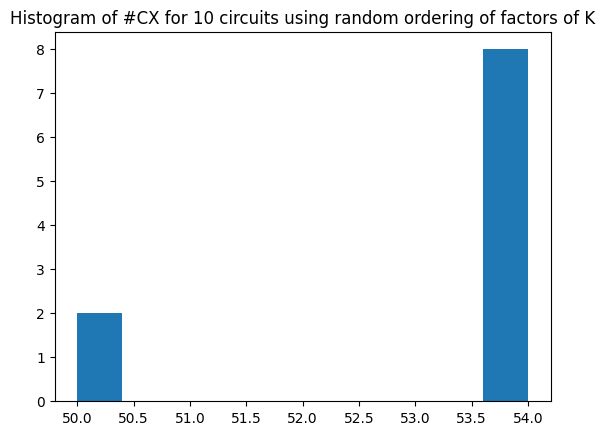

In [38]:
# Plot Histogram.
from matplotlib import pyplot as plt
plt.hist(num_cx_list)
plt.title(f"Histogram of #CX for {size} circuits using random ordering of factors of K")

In [39]:
# Compare above distribution with a lexicographic ordering of factors of K.

# Specify Ham and corresponding undecomposed circuit.
ham_terms = ["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"]
test_heisenberg_ham = SparsePauliOp(data=ham_terms, 
                                    coeffs=np.ones(len(ham_terms), dtype=int))
test_paulievolutiongate = PauliEvolutionGate(operator=test_heisenberg_ham, 
                                             time=test_time_evolve,
                                             synthesis=HighLevelSynthesis())
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

# Create HLS pass manager but with a -1 seed, corresponding to lexicographic ordering.
hls_config_lexicographic = HLSConfig(PauliEvolution=[("cartan", {"random_seed":-1, "involution": "evenOdd"})])
pm_hls_lex = PassManager()
pm_hls_lex.append(HighLevelSynthesis(hls_config=hls_config_lexicographic))

# First PassManager. qc_before is the same input circuit as the previous cell.
qc_hls_lex = pm_hls_lex.run(qc_before) # HLS

# Second PassManager (the same as the previous cell), but the input is now qc_hls_lex.
# qc_i = pm_other.init.run(qc_before)
qc_l_lex = pm_other.layout.run(qc_hls_lex) # map virtual to physical
qc_r_lex = pm_other.routing.run(qc_l_lex) # SABRE
qc_t_lex = pm_other.translation.run(qc_r_lex) # unroller
qc_o_lex = pm_other.optimization.run(qc_t_lex) # optimization

# Get #CX.
qc_o_lex.count_ops()['cx']

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
--- 0.09215188026428223 seconds ---
Optimization Error:
2.6437608884482626e-12


54

In [40]:
# Check that the transpiled circuit is close to the original circuit by evaluating
# matrix norm of their difference.

qc_o_lex_unitarysim = transpile(qc_o_lex, unitary_simulator)
cartan_propagator_matrix = Operator(qc_o_lex).data

original_propagator_matrix_brute = scipy.linalg.expm(-1j*test_heisenberg_ham.to_matrix()*test_time_evolve)

print("ideal propagator matrix: ")
display(array_to_latex(original_propagator_matrix_brute))

print("lexicographic cartan propagator matrix: ")
display(array_to_latex(cartan_propagator_matrix))

print("frobenius norm of their difference: ", 
      np.linalg.norm(original_propagator_matrix_brute - cartan_propagator_matrix, ord="fro"))

ideal propagator matrix: 


<IPython.core.display.Latex object>

lexicographic cartan propagator matrix: 


<IPython.core.display.Latex object>

frobenius norm of their difference:  6.415410082577599e-07


#### Compare with optimal circuit as sent by Nick (should see 18 CXs). However, observe that the matrix elements are not quite the same due to the presence of an extra chiral term. Nonetheless, the nonzero matrix elements are in the same places as our 3q NN Ham.

In [41]:
from qiskit.circuit import Gate, Parameter, ParameterVector, QuantumCircuit, QuantumRegister
from qiskit.opflow import PauliTrotterEvolution, Suzuki, I, X, Y, Z

from typing import List, Optional, Union

class Vik(Gate):

    """Vik gate definition: Heisenberg Hamiltonian with signs 
    determined by anti-commuting Paulis for twirling."""

    def __init__(self, 
        tt: Union[float, Parameter], 
        signs: Optional[Union[List[int], ParameterVector]] = [1, 1, 1],
    ):
        """
        Initialize Vik gate.

        Args:
            tt (Union[float, Parameter]): time of unitary evolution.
            signs (Optional[Union[List[int], ParameterVector]], optional): Signs of coefficients
                for use with Pauli twirling. Defaults to [1, 1, 1] in case of no twirling.
        """        
        super().__init__("$V_{ik}$", 2, [tt, signs[0], signs[1], signs[2]])

    def _define(self):

        """
        Generate Gate definion.

        TODO: Switch from using qiskit.opflow to qiskit.quantum_info.
        """        

        tt = self.params[0]
        signs = [self.params[1], self.params[2], self.params[3]]

        qr = QuantumRegister(2, 'q')
        qc = QuantumCircuit(qr)
        # h2 = signs[0]*SparsePauliOp('XX') + signs[1]*SparsePauliOp('YY') + signs[2]*SparsePauliOp('ZZ')
        h2 = signs[0]*(X^X) + signs[1]*(Y^Y) + signs[2]*(Z^Z)
        # qc.append(PauliEvolutionGate(h2, time=tt), [qr[0], qr[1]])
        u2 = (h2*tt).exp_i()

        # self.definition = qc
        self.definition = PauliTrotterEvolution(trotter_mode=Suzuki(order=1), reps=1).convert(u2).to_circuit()
    
class U3(Gate):

    """U3 Gate Definition"""

    def __init__(self, 
        tt: Union[float, Parameter], 
        signs01: Optional[Union[List[int], ParameterVector]] = [1, 1, 1],
        signs12: Optional[Union[List[int], ParameterVector]] = [1, 1, 1],
    ):
        """
        Initialize U3 gate.

        Args:
            tt (Union[float, Parameter]): time of unitary evolution.
            signs01 (Optional[Union[List[int], ParameterVector]], optional): Signs for evolution on [q0, q1]
                register. Defaults to [1, 1, 1] in case of no twirling.
            signs12 (Optional[Union[List[int], ParameterVector]], optional): Signs for evolution on [q1, q2]
                register. Defaults to [1, 1, 1] in case of no twirling.
        """        
        super().__init__("U3(t)", 3, [tt, signs01[0], signs01[1], signs01[2],
                                      signs12[0], signs12[1], signs12[2]])

    def _define(self):

        """
        Generate gate definition in terms of Vik gates.
        """        
        
        tt = self.params[0]
        signs01 = [self.params[1], self.params[2], self.params[3]] 
        signs12 = [self.params[4], self.params[5], self.params[6]]

        qr = QuantumRegister(3, 'q')
        qc = QuantumCircuit(qr)
        # np.pi/8 due to sqrt(SWAP) gate
        qc.append(Vik(0.5*tt + 0.125*np.pi, signs01), [qr[0], qr[1]])
        qc.append(Vik(2*tt, signs12), [qr[1], qr[2]])
        qc.append(Vik(0.5*tt - 0.125*np.pi, signs01), [qr[0], qr[1]])

        self.definition = qc

tt = Parameter('t')

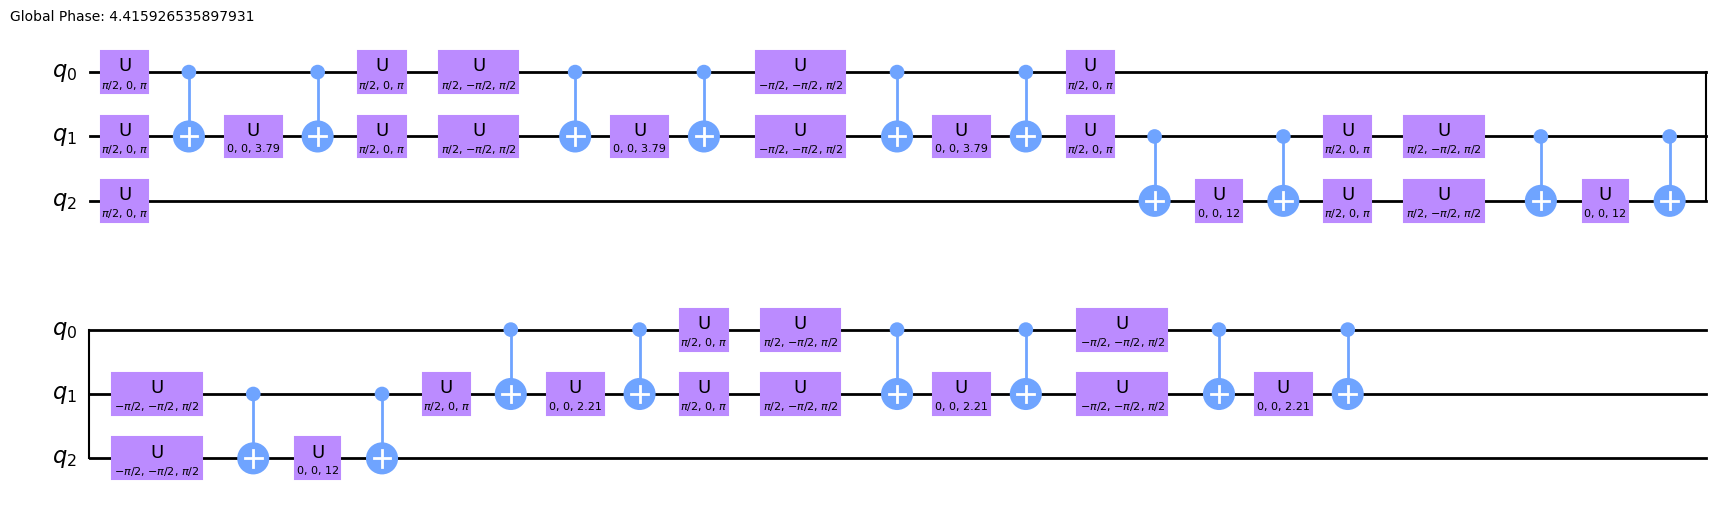

In [42]:
qc = QuantumCircuit(3)
qc.append(U3(tt=3), [0, 1, 2])
qc_opt = qc.decompose(reps=20)
qc_opt.draw("mpl")

In [43]:
print("optimal number of cx (but extra chiral term present in Hamiltonian):", qc_opt.count_ops()["cx"])

optimal number of cx (but extra chiral term present in Hamiltonian): 18


In [44]:
opt_propagator_matrix = Operator(qc_opt).data
print("optimal propagator matrix with extra chiral term: ")
display(array_to_latex(opt_propagator_matrix))

print("ideal propagator matrix: ")
display(array_to_latex(original_propagator_matrix_brute))

print(f"trace of their product (one of them is Hermitian transposed) divided by dimension: \n",
    np.trace(opt_propagator_matrix.conjugate().transpose() * original_propagator_matrix_brute))

optimal propagator matrix with extra chiral term: 


<IPython.core.display.Latex object>

ideal propagator matrix: 


<IPython.core.display.Latex object>

trace of their product (one of them is Hermitian transposed) divided by dimension: 
 (-6.749020667388567+0.12203756207344581j)


#### 3q NNN-open Heisenberg Ham on 4q branched backend

Same as before: generate many circuits, each corresponding to a random ordering of factors in K. Then feed each of the circuits above into a preset pass manager (the default pass managers used by the transpile() function) and get #CX gates. Then compare distribution of #CX with that resulting from a lexicographic ordering of factors in K.

We use the same Hamiltonian as above 
except append an identity for 0th qubit: IIXX, IXXI, ...
with coupling_map = [[0, 1], [0, 2], [0, 3], [1, 0], [2, 0], [3, 0]],
i.e qubit 0 is the central qubit with branches to each of the other qubits.

In [49]:
# Specify number of circuits to generate.
size = 50

# Specify Ham and corresponding undecomposed circuit.
ham_terms = ["IXXI", "IYYI", "IZZI", "IIXX", "IIYY", "IIZZ"]
test_heisenberg_ham = SparsePauliOp(data=ham_terms, 
                                    coeffs=np.ones(len(ham_terms), dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, time=test_time_evolve)
qc_before = QuantumCircuit(4)
qc_before.append(test_paulievolutiongate, range(4))

# Create a PassManager objects containing the rest
# of the transpilation options.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import CouplingMap

pm_other = generate_preset_pass_manager(optimization_level=3, 
                                        layout_method="trivial",
                                        coupling_map=CouplingMap([[0, 1], [0, 2], [0, 3], [1, 0], [2, 0], [3, 0]]), 
                                        routing_method="sabre",
                                        translation_method="unroller",
                                        basis_gates="['u1', 'u2', 'u3', 'cx']",
                                        seed_transpiler=1)

# Generate transpiled circuits.
qc_list = []
random.seed(3)
different_seeds = random.sample(range(1, 101), size) # WLOG choose to generate random numbers between 1 and 100
for i in range(size):
    
    # Create a PassManager object containing just the custom HLS pass.
    hls_config = HLSConfig(PauliEvolution=[("cartan", {"random_seed":different_seeds[i], "involution":"evenOdd"})])
    pm_hls = PassManager()
    pm_hls.append(HighLevelSynthesis(hls_config=hls_config))

    # First PassManager.
    qc_hls = pm_hls.run(qc_before) # HLS

    # Second PassManager.
    qc_l = pm_other.layout.run(qc_hls) # map virtual to physical
    qc_t = pm_other.translation.run(qc_l) # unroller
    qc_r = pm_other.routing.run(qc_t) # SABRE
    qc_o = pm_other.optimization.run(qc_r) # optimization

    qc_list.append(qc_o)

# Get CX distribution
num_cx_list = [qc.count_ops()['cx'] for qc in qc_list]
display(num_cx_list)

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 24
         Function evaluations: 30
         Gradient evaluations: 30
--- 0.10072779655456543 seconds ---
Optimization Error:
1.8114475147063485e-12
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20
--- 0.06663036346435547 seconds ---
Optimization Error:
2.1285593992386928e-11
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -0.271988
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
--- 0.03861117362976074 seconds ---
Optimization Error:
4.3433316091980675e-11
Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 19

[57,
 57,
 57,
 57,
 63,
 61,
 57,
 63,
 63,
 57,
 53,
 57,
 61,
 61,
 59,
 57,
 57,
 59,
 57,
 57,
 57,
 63,
 61,
 63,
 61,
 57,
 63,
 53,
 61,
 59,
 53,
 63,
 63,
 57,
 63,
 57,
 57,
 57,
 61,
 53,
 57,
 53,
 57,
 59,
 59,
 53,
 57,
 57,
 63,
 57]

In [50]:
min_index = num_cx_list.index(min(num_cx_list))

qc_list[min_index].draw()

global phase: 4.4292
                                ┌───┐     ┌───┐                        »
q_0: ─────────────────────■─────┤ X ├──■──┤ X ├──■──────────────────■──»
     ┌──────────────┐     │     └─┬─┘  │  └─┬─┘┌─┴─┐┌────────────┐┌─┴─┐»
q_1: ┤ U(π/2,0,π/2) ├─────┼───────┼────┼────┼──┤ X ├┤ U1(-0.291) ├┤ X ├»
     └──────────────┘   ┌─┴─┐     │  ┌─┴─┐  │  └───┘└────────────┘└───┘»
q_2: ───────────────────┤ X ├─────■──┤ X ├──┼──────────────────────────»
                     ┌──┴───┴──┐     └───┘  │                          »
q_3: ────────────────┤ U2(0,π) ├────────────■──────────────────────────»
                     └─────────┘                                       »
«                        ┌───┐                   ┌───┐                         »
«q_0: ───────────────────┤ X ├───────────────────┤ X ├──■───────────────────■──»
«     ┌─────────────────┐└─┬─┘                   └─┬─┘┌─┴─┐┌─────────────┐┌─┴─┐»
«q_1: ┤ U(π/2,-π/2,π/2) ├──┼───────────────────────┼──┤ X ├┤ U1(0.23158) ├┤ X ├»
«     └─────────────────┘  │                       │  └───┘└─────────────┘└───┘»
«q_2: ─────────────────────┼───────────────────────┼───────────────────────────»
«                          │  ┌─────────────────┐  │                           »
«q_3: ─────────────────────■──┤ U(π/2,π/2,-π/2) ├──■───────────────────────────»
«                             └─────────────────┘                              »
«                        ┌───┐   ┌─────────┐   ┌───┐                        »
«q_0: ───────────────────┤ X ├───┤ U2(0,π) ├───┤ X ├──■──────────────────■──»
«     ┌─────────────────┐└─┬─┘   └─────────┘   └─┬─┘┌─┴─┐┌────────────┐┌─┴─┐»
«q_1: ┤ U(π/2,π/2,-π/2) ├──┼─────────────────────┼──┤ X ├┤ U1(2.5021) ├┤ X ├»
«     └─────────────────┘  │                     │  └───┘└────────────┘└───┘»
«q_2: ─────────────────────┼─────────────────────┼──────────────────────────»
«                          │  ┌───────────────┐  │                          »
«q_3: ─────────────────────■──┤ U(π/2,π/2,-π) ├──■──────────────────────────»
«                             └───────────────┘                             »
«     ┌─────────────────┐                                    ┌───┐»
«q_0: ┤ U(π/2,π/2,-π/2) ├──■───────────────────■─────────────┤ X ├»
«     ├─────────────────┤┌─┴─┐┌─────────────┐┌─┴─┐┌─────────┐└─┬─┘»
«q_1: ┤ U(π/2,-π/2,π/2) ├┤ X ├┤ U1(0.59103) ├┤ X ├┤ U2(0,π) ├──┼──»
«     └─────────────────┘└───┘└─────────────┘└───┘└─────────┘  │  »
«q_2: ─────────────────────────────────────────────────────────┼──»
«                                                              │  »
«q_3: ─────────────────────────────────────────────────────────■──»
«                                                                 »
«     ┌─────────────────┐┌───┐                         ┌───┐┌─────────────────┐»
«q_0: ┤ U(π/2,-π/2,π/2) ├┤ X ├──■───────────────────■──┤ X ├┤ U(π/2,π/2,-π/2) ├»
«     └─────────────────┘└─┬─┘┌─┴─┐┌─────────────┐┌─┴─┐└─┬─┘└─────────────────┘»
«q_1: ─────────────────────┼──┤ X ├┤ U1(-2.3728) ├┤ X ├──┼─────────────────────»
«                          │  └───┘└─────────────┘└───┘  │                     »
«q_2: ─────────────────────┼─────────────────────────────┼─────────────────────»
«       ┌──────────────┐   │                             │  ┌─────────────────┐»
«q_3: ──┤ U(π/2,0,π/2) ├───■─────────────────────────────■──┤ U(π/2,-π/2,π/2) ├»
«       └──────────────┘                                    └─────────────────┘»
«     ┌───┐                         ┌───┐┌───────────────┐ ░ ┌───┐┌─────────┐»
«q_0: ┤ X ├──■───────────────────■──┤ X ├┤ U(π/2,π/2,-π) ├─░─┤ X ├┤ U1(-12) ├»
«     └─┬─┘┌─┴─┐┌─────────────┐┌─┴─┐└─┬─┘└───────────────┘ ░ └─┬─┘└─────────┘»
«q_1: ──┼──┤ X ├┤ U1(0.80315) ├┤ X ├──┼────────────────────░───■─────────────»
«       │  └───┘└─────────────┘└───┘  │                    ░                 »
«q_2: ──┼─────────────────────────────┼────────────────────░─────────────────»
«       │                             │     ┌─────────┐    ░                

Text(0.5, 1.0, '#CX of 50 circuits using random ordering of factors of K')

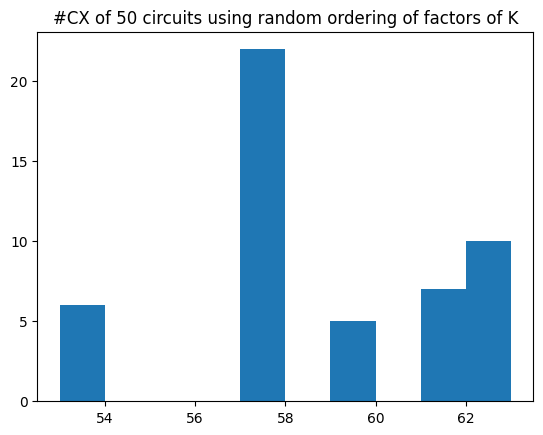

In [51]:
# Plot Histogram.
from matplotlib import pyplot as plt
plt.hist(num_cx_list)
plt.title(f"#CX of {size} circuits using random ordering of factors of K")

In [52]:
# Create a PassManager object containing just the custom HLS pass.
hls_config_lexicographic = HLSConfig(PauliEvolution=[("cartan", {"random_seed":-1, "involution":"evenOdd"})]) # lexicographic
pm_hls_lex = PassManager()
pm_hls_lex.append(HighLevelSynthesis(hls_config=hls_config_lexicographic))

# First PassManager.
qc_hls_lex = pm_hls_lex.run(qc_before) # HLS

# Second PassManager.
qc_l_lex = pm_other.layout.run(qc_hls_lex) # map virtual to physical
qc_t_lex = pm_other.translation.run(qc_l_lex) # unroller
qc_r_lex = pm_other.routing.run(qc_t_lex) # SABRE
qc_o_lex = pm_other.optimization.run(qc_r_lex) # optimization

# Get #CX.
qc_o_lex.count_ops()['cx']

Running Cartan Synthesis Plugin...
Optimization terminated successfully.
         Current function value: -2.303234
         Iterations: 23
         Function evaluations: 29
         Gradient evaluations: 29
--- 0.11031556129455566 seconds ---
Optimization Error:
2.6437608884482626e-12


57

# Appendix

Note how it is crucial to use `synthesis=MatrixExponential()` when creating the PauliEvolutionGate, in order to represent the corresponding unitary matrix exactly. Otherwise the default method is LieTrotter with one repetition.

In [ ]:
from qiskit.synthesis import MatrixExponential

test_heisenberg_ham = SparsePauliOp(["XXI", "YYI", "ZZI", "IXX", "IYY", "IZZ"], 
                                    coeffs = np.ones(6, dtype=int))
test_paulievolutiongate = PauliEvolutionGate(test_heisenberg_ham, 
                                             time=test_time_evolve, 
                                             synthesis=MatrixExponential())
qc_before = QuantumCircuit(3)
qc_before.append(test_paulievolutiongate, range(3))

qc_before.draw()

from qiskit import Aer, transpile
unitary_simulator = Aer.get_backend('unitary_simulator')

qc_before_sim = transpile(qc_before, unitary_simulator)
# inspect intermediate stages

original_propagator_matrix = unitary_simulator.run(qc_before_sim).result().get_unitary().to_matrix()

original_propagator_matrix_brute = scipy.linalg.expm(-1j*test_heisenberg_ham.to_matrix()*test_time_evolve)

np.linalg.norm(original_propagator_matrix - original_propagator_matrix_brute, ord="fro")


0.0

In [ ]:
from qiskit.visualization import array_to_latex
display(array_to_latex(original_propagator_matrix))
display(array_to_latex(original_propagator_matrix_brute))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>